# Multi-point stress approximation - walkthrough of tutorial
This notebook focuses on dissembling the `mpsa` notebook. The equations and code is looked at in detail

# Equation and physics

The linear elasticity problem may be represented with the following equation,
$$\nabla \cdot \sigma = - \vec{f}, \quad \vec{x} \in \Omega$$
where $\vec{f}$ is a body force, and $\sigma$ is the stress tensor. Stress is in PorePy represented as a linear function of the displacement
$$\sigma = C : \vec{u}$$

*Porepy* uses the following conventions:
* *tension* is positive. I.e.: The Cartesian component of the traction $\vec{T} = \sigma \cdot \vec{n}$, for a direction $\vec{r}$ is a positive number if the inner product $\vec{T}\cdot\vec{r}$ is positive. (This is opposite to the convection in *Fundamentals of Rock Mechanics*)
* The displacement vector given by $\vec{u}$ points from the initial state $\vec{x}$ to the final state $\vec{x}^*$, i.e. $\vec{u} = \vec{x}^* - \vec{x}$.

The system is bounded by three possible boundary conditions; Neumann, Dirichlet, or Robin conditions. Dividing the boundary into disjoint sets $\Gamma_N$, $\Gamma_D$, and $\Gamma_R$ for the types of conditions, we have
\begin{equation}
\vec{u} = g_D, \quad \vec{x} \in \Gamma_D \\
\sigma \cdot n = g_N, \quad \vec{x} \in \Gamma_N \\
\sigma \cdot n + W \vec{u} = g_R, \quad \vec{x} \in \Gamma_R
\end{equation}

## Create a non-fractured grid

In [82]:
import numpy as np
import porepy as pp
import scipy.sparse as sps

# Create grid
n = 5
physdims = [1,1]
g = pp.CartGrid([n,n], physdims=physdims)
g.compute_geometry()

Next, we define the stress tensor $C$. The constutitive law,
\begin{equation}
\sigma = C : u = 2 \mu \epsilon + \lambda \text{trace} (\epsilon) I, \quad \epsilon = \frac{1}{2} (\nabla u + (\nabla u)^T)
\end{equation}
is implemented.
Here, $\sigma$ is the stress, $C$ is the linear mapping of stress and displacement (or strain). $\mu$ is the shear modulus, and $\lambda$ is the Lame parameter. $\epsilon$ is the strain.
Thus, defining $\lambda$ and $\mu$, we are able to provide the relationship between stress and strain.

According to Keilegavlen et. al. (2017), the representation of stress, outlined above, is valid only for the case of isotropic media. Otherwise, $C$ (the stiffness tensor) has to be expressed more generally.

The static momentum balance equation for an elastic medium, in Lagrangian coordinates are
\begin{equation}
\int_{\partial\Omega}\boldsymbol{T}(\boldsymbol{n})dA + \int_{\Omega} \boldsymbol{f} dV = 0
\end{equation}
where $\boldsymbol{T}(\boldsymbol{n})$ are the surface traction vectors on the boundary $\partial \Omega$ of the domain $\Omega$. Here, $\boldsymbol{n}$ is the outward facing normal vector, and $\boldsymbol{f}$ represents body forces. Under the assumption of a linear stress-strain relation and small deformation, we may write
\begin{equation}
\boldsymbol{T}(\boldsymbol{n}) = \boldsymbol{\pi}\cdot\boldsymbol{n} = (C:\epsilon)\cdot\boldsymbol{n}
\end{equation}
In this context, $\boldsymbol{\pi}$ represents "the first Piola-Kirchhoff stress tensor", $C$ is the stiffness tensor and $\boldsymbol{\epsilon}$ is the symmetric part of the strain $\boldsymbol{\epsilon} = (\nabla\boldsymbol{u} + (\nabla\boldsymbol{u})^T)/2$. In Euclidean space, under the assumption of small deformations, the Piola-Kirchhoff stress tensors are exactly the Cauchy stress tensor - and are symmetric.

The differences between the two stresses may be illuminated (slightly) by the following wikipedia page:
* https://en.wikipedia.org/wiki/Stress_measures#Nominal_stress/First_Piola-Kirchhoff_stress \
_Question:_ The wikipedia page mentions that the Kirchhoff stress is a "two-point stress tensor like the deformation gradient". Keilegavlen's article refers to $\epsilon = (\nabla u + (\nabla u)^T)/2$ as a deformation gradient. (I called it "strain", just above, referencing notation in the Rock Mechanics book). What is this? Is it important? \
Link: https://en.wikipedia.org/wiki/Two-point_tensor

In [83]:
# Create stiffness matrix
lam = np.ones(g.num_cells)
mu = np.ones(g.num_cells)
C = pp.FourthOrderTensor(mu, lam)

Boundary conditions are set to
* Bottom boundary, dirichlet
* Otherwise, Neumann

In [84]:
# Boundary type
dirich = np.ravel(np.argwhere(g.face_centers[1] < 1e-10))
labels = ['dir']*dirich.size
bound = pp.BoundaryConditionVectorial(g, dirich, labels)

Next step: Put values on the boundaries. In this example we \
1. clamp the bottom boundary
2. push down by a constant force on the top boundary (this is the integrated traction over the face)

In [85]:
tol = 1e-10
top_faces = np.ravel(np.argwhere(g.face_centers[1] > physdims[1] - tol))
bot_faces = np.ravel(np.argwhere(g.face_centers[1] < tol))

u_b = np.zeros((g.dim, g.num_faces))
u_b[1, top_faces] = -1 * g.face_areas[top_faces]
u_b[:, bot_faces] = 0

u_b = u_b.ravel('F')

The discretization scheme used is the multi-point stress approximation. See Keilegavlen et al 2017 for details. \
This is implemented by the Mpsa class in PorePy.

Here, we let body forces $f=0$

In [86]:
mpsa = pp.Mpsa("mechanics")
f = np.zeros(g.dim * g.num_cells)

specified_parameters = {"fourth_order_tensor": C, "source": f, "bc": bound, "bc_values": u_b}
data = pp.initialize_default_data(g, {}, "mechanics", specified_parameters)
mpsa.discretize(g, data)
A, b = mpsa.assemble_matrix_rhs(g, data)

u = sps.linalg.spsolve(A, b)

We can plot the y_displacement. \
Note that the notation `u[1::2]` retrieves every second element (hence the `2`), except we skip the first value (hence `1` instead of implicit `0`). \
Because of the way we set up the problem - everything is "flattened" - `u` is ordered by $[u_{x_0}, u_{y_0}, u_{x_1}, u_{y_1}, u_{x_2}, u_{y_2}, ...]$, where the subscripts refer to x and y components at a given index.

/home/haakon/anaconda3/lib/python3.7/site-packages/mpl_toolkits/mplot3d/axes3d.py:753: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0.0, top=0.0
  'bottom=%s, top=%s') % (bottom, top))


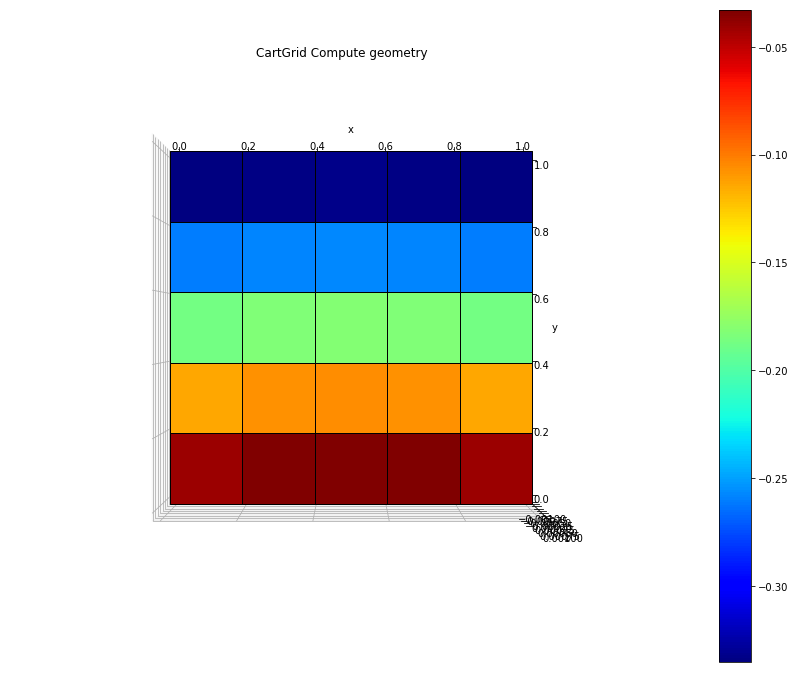

In [87]:
pp.plot_grid(g, cell_value=u[1::2], figsize=(15, 12))

Equivalently, we can plot the x-displacements:

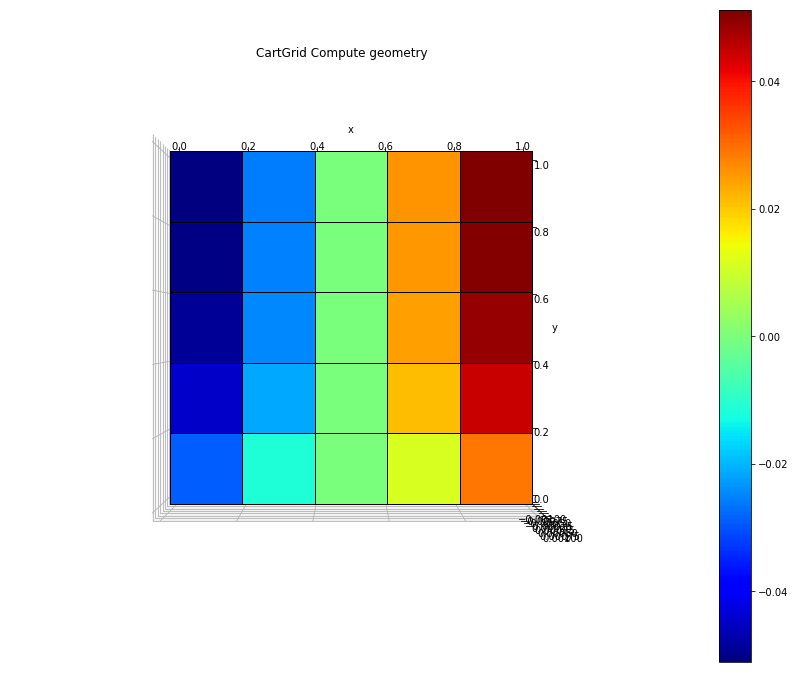

In [88]:
pp.plot_grid(g, cell_value=u[::2], figsize=(15, 12))

### Deconstruct the assembly process

Following the tutorial, we assemble the system manually:

In [89]:
constit = pp.FourthOrderTensor(mu, lam)
stress, bound_stress, *_ = pp.numerics.fv.mpsa.mpsa(g, constit, bound)

The discretization provides us two sprase matrices, `stress` and `bound_stress`. \
They define the discretization of the **CELL-FACE TRACTION**: (_What does that mean????_)
\begin{equation}
T = \text{stress} \cdot u + \text{bound_stress} \cdot u_b
\end{equation}
Here, $u$ is a vector of cell center displacement with length `g.dim * g.num_cells`. $u_b$ contains the boundary condition values. We have displacement for dirichlet and traction for neumann, with length `g.dim * g.num_faces`.

Next, we set up the linear system of equations. Let the body forces, $f=0$. Then, each row in the discretized system is
\begin{equation}
- \int_{\Omega_k} f\ dv = \int_{\partial\Omega_k} T(n) \ dA = [ div \cdot \text{stress} \cdot u + div \cdot \text{bound_stress} \cdot u_b ]_k,
\end{equation}

We move the known value $u_b$ over to the other side and solve

In [90]:
f = np.zeros(g.dim * g.num_cells)

div = pp.fvutils.vector_divergence(g)
A = div * stress
b = -f - div * bound_stress * u_b

u_manual = sps.linalg.spsolve(A, b)

Confirm that the solutions are the same

In [91]:
assert np.allclose(u, u_manual)